# Section 7: Harmonic Analysis using CAR maps

Now that users are able to import and examine these maps we now present an introduction to harmonic analysis using these maps.  We will present and example of a simple ACT Planck cross correlation here but we encourage users to consider cross correlations with other maps or galaxy density maps.

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Advanced_ACT_DR4_Combined_data_products.ipynb): Introduction and Importing Pixell, Healpy and other key packages

> [Section 2](coadded_maps.ipynb): S08-18 Coadded maps and an Introduction to Pixell

> [Section 3](HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to converted maps between HEALPix format and the CAR format.

> [Section 4](stacking.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> Section 5:  Introduction to the Lensing maps.

> Section 6:  Guide to the use of the Component Separated maps.

> Section 7:  Harmonic Analysis with CAR Maps

> Section 8:  Looks at how to generate E and B maps from I, Q, U maps.  <font color=red>(perhaps skip this or move it later)</font>

## Initialize notebook

We begin by importing Pixell and other neccesary functions by running the introductory notebook.

We will also run the coadded_maps notebook which reads in the ACT map and then the HEALPix_CAR_Conversions notebook which reads in a planck map and converts it from HEALPix format to the CAR format used for ACT maps.


In [1]:
%run Advanced_ACT_DR4_Combined_data_products.ipynb

%run coadded_maps.ipynb

%run HEALPix_CAR_Conversions.ipynb

NameError: name 'eshow' is not defined

### Fourier transforms using Enmap

We will begin by trimming both ACT and Planck maps to the same size and then use enmap's functions to Fourier transform the map using the 'flat-sky' approximation.  

Before Fourier transforming the maps it is necessary to apodize the edges of the maps so that periodic boundary conditions apply.  This can easily be done using the enmap functions and the taper can be adjusted by changing the 'apod_pix' variable which adjusts the number of pixels that are apodized.

Here we chose to display only the I maps, however, the Q and U maps can of course be tapered in the same manner if desired.

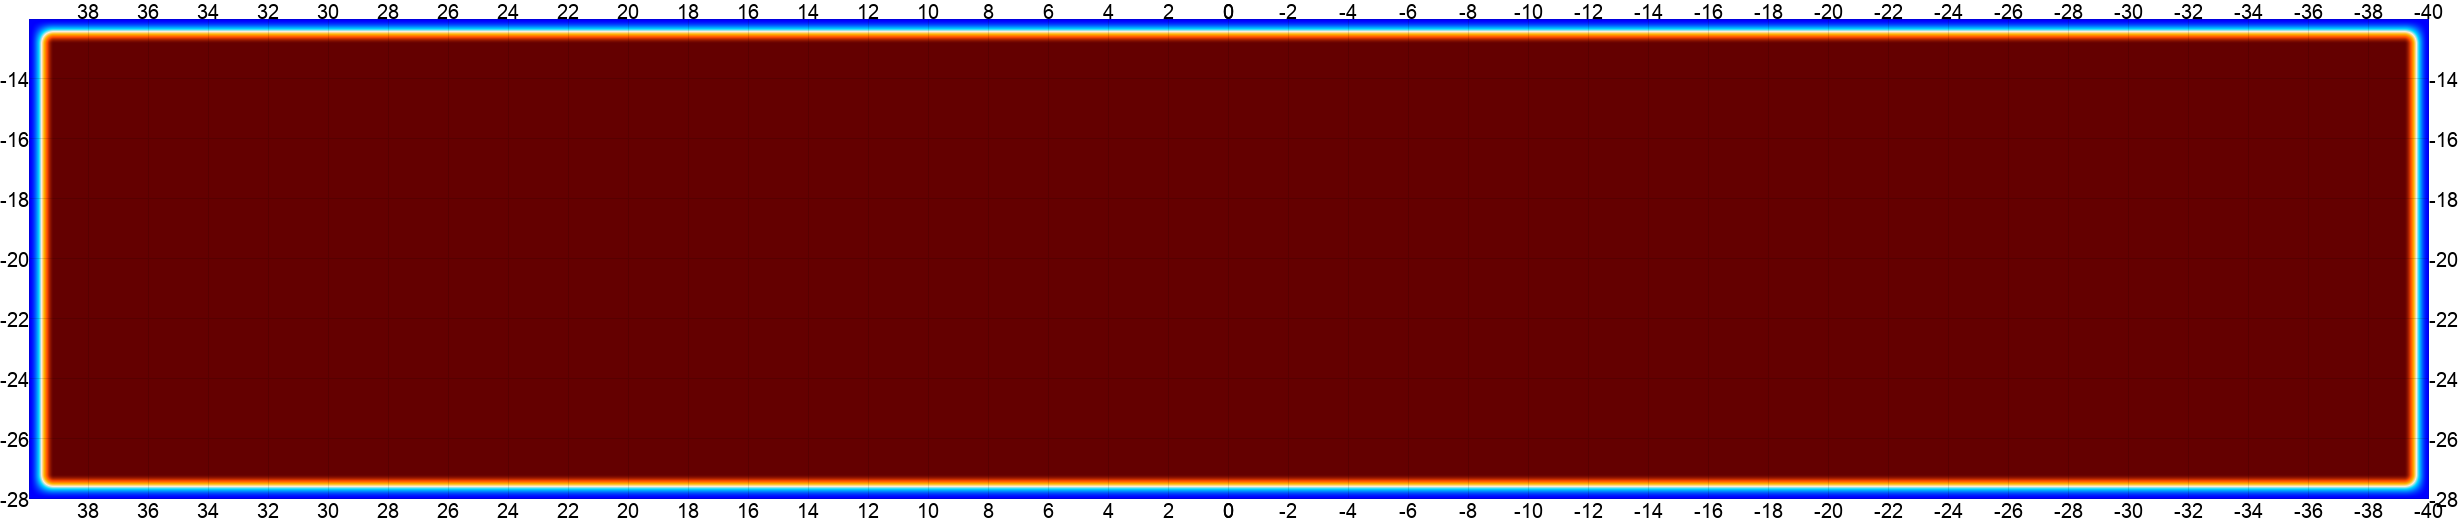

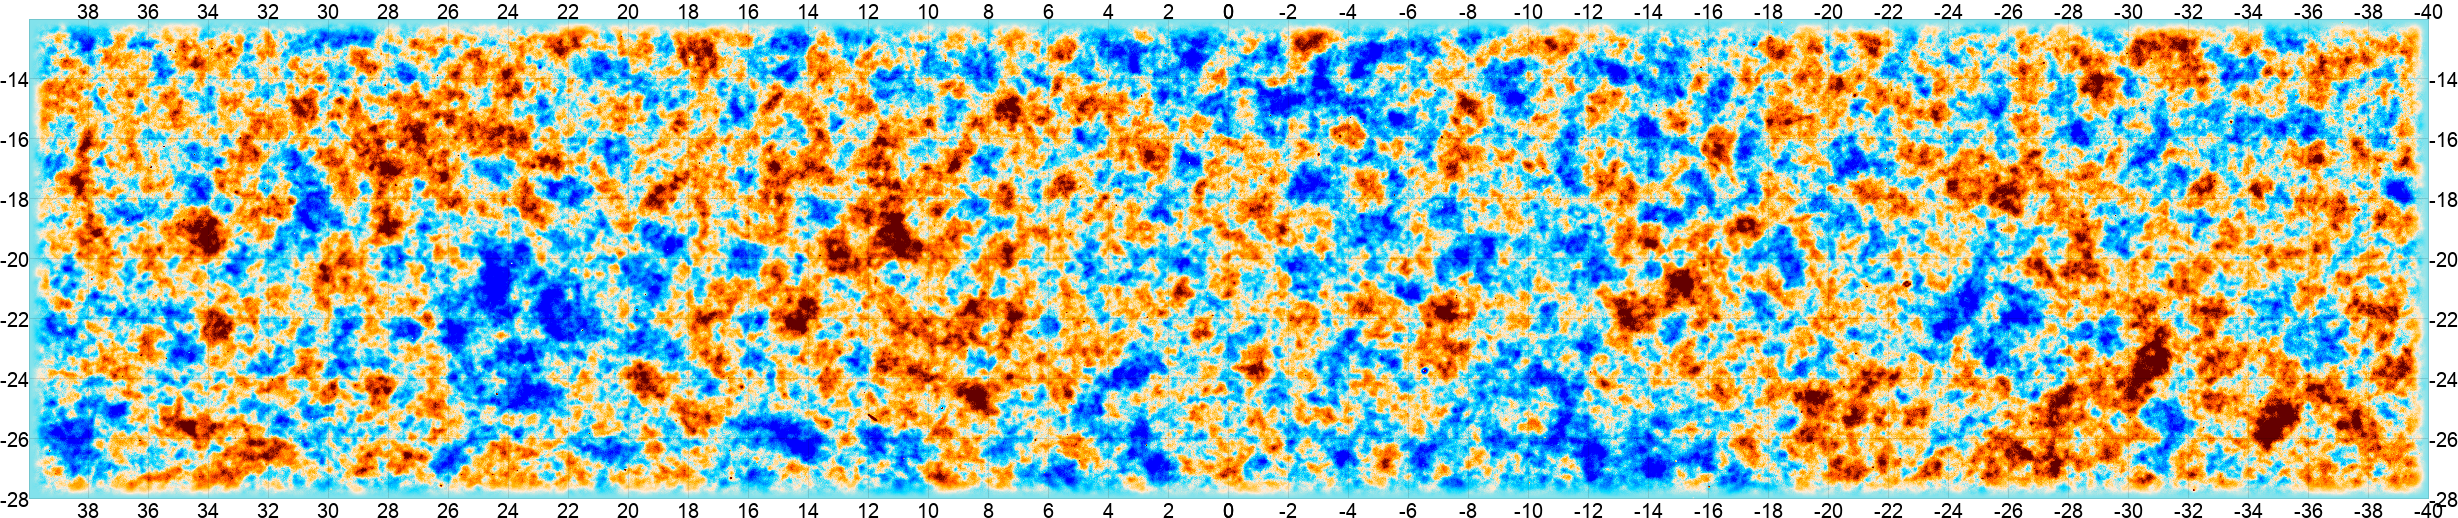

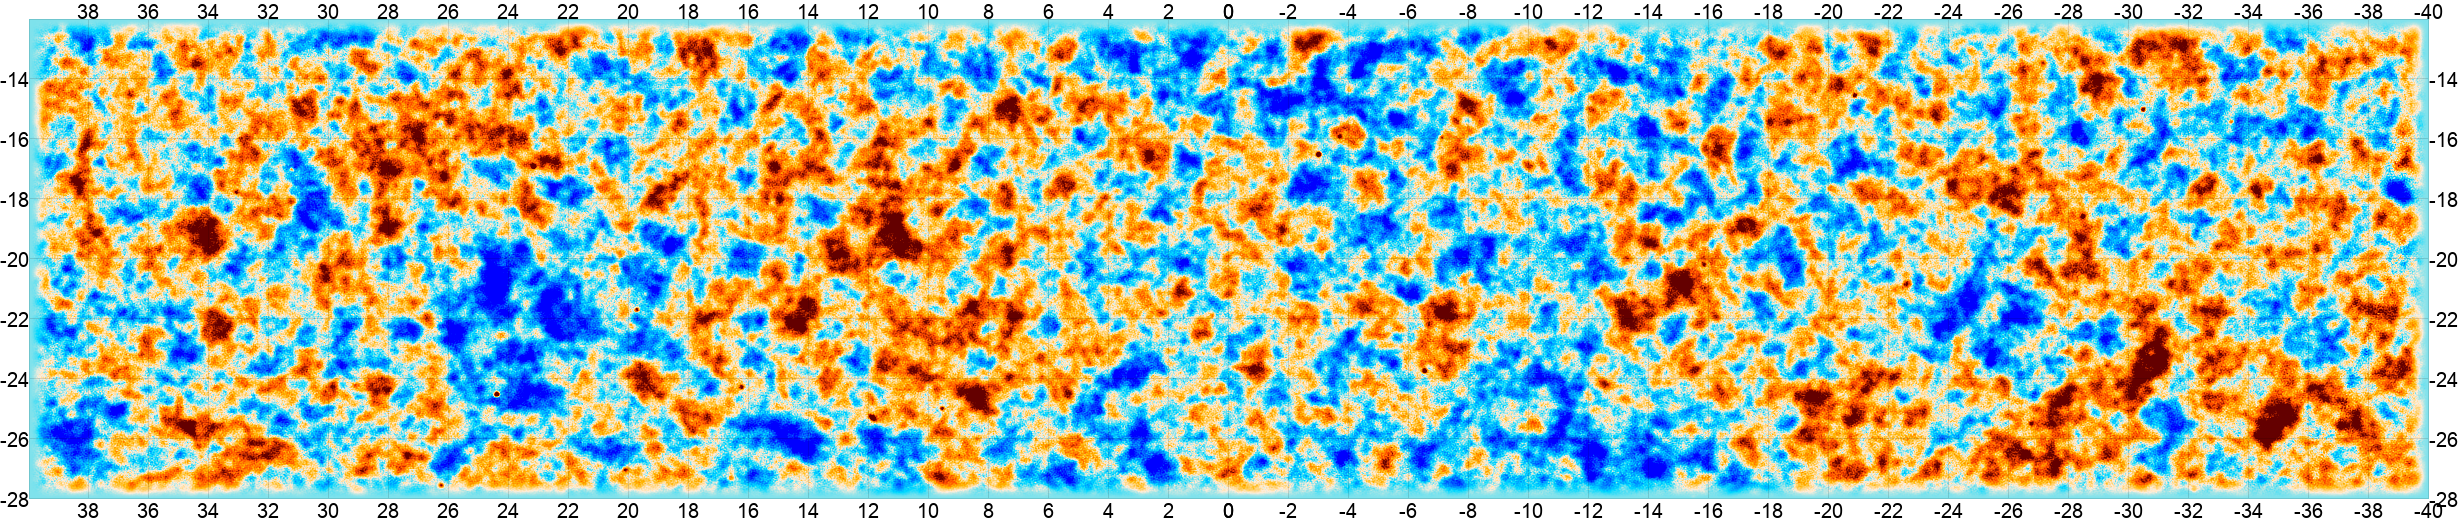

In [28]:
# Trim Maps
box = np.array([[-28,40],[-12,-40]])*utils.degree
smap_act    = smap_2.submap(box)
smap_planck = planck_map.submap(box)

# Define taper using enmap.apod and then plot the taper
apod_pix = 100 
taper    = enmap.apod(smap_act*0+1,apod_pix) 
eshow(taper,  **{"downgrade": 4, "ticks": 2})

# Apply taper to the two maps by multiplying the taper and maps together
eshow(taper*smap_act, **{"downgrade": 4,  "ticks": 2})
eshow(taper*smap_planck[0], **{"downgrade": 4,  "ticks": 2})

Now that we have the apodized maps we can begin the harmonic analysis.  

Step one is to use enmap to get a Fourier transformation of the map.  For ease of use we set the normalization of the Fourier transformation to physical by passing the 'phys' parameter.  This makes Pixell take into account pixel area factors when calculating the power.

Once you have the Fourier transformed map it is possible to make a naive power spectra by multiplying by the conjugate and then binning the spectra.

One thing we note is that Pixell has a function that lets you call the 'modlmap' of a ndmap.  This is a map that gives the distance in Fourier space of each pixel to the center of the map.  It's particularly useful for binning the power spectra and we will use it in the binning function below.

In order to get the Planck maps in $\mu$K we multiply by a factor of $10^6$ 

In [29]:
# Fourier transform the map:
kmap_act = enmap.fft(smap_act*taper, normalize = 'phys')
kmap_planck = enmap.fft(smap_planck[0]*taper*1e6, normalize = 'phys')

# Get power
power = (kmap_act*np.conj(kmap_planck)).real

# Define a function that can bin the power.  
def bin(data,imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0,lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

# The Taper we applied earlier effects tge power spectrum. 
# Pixell doesn't have the capability to fully account for the taper
# But we can get an approximate correction by dividing out the following term
w2 = np.mean(taper**2)

ell_b, binned_power = bin(power/w2, smap_act, lmax = 6000, bin_size = 40)

Now that we've binned the power spectrum we made we can plot it quickly to have a look at it.

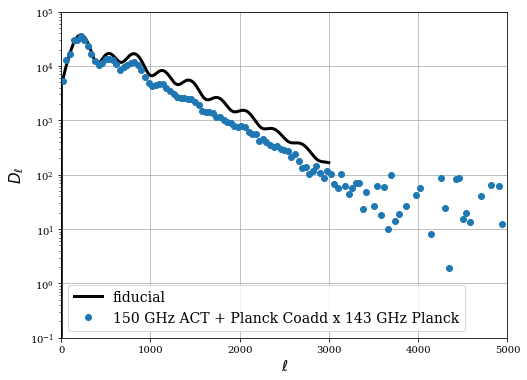

In [30]:
# Read in a camb fiducial spectrum for comparison
from pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ls,cltt*ls**2.,lw=3,color='k', label = "fiducial")
plt.plot(ell_b,ell_b**2*binned_power,marker="o",ls="none", label = "150 GHz ACT + Planck Coadd x 143 GHz Planck")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.xlim(0, 5000)
plt.ylim(.1, 1e5)
plt.grid(True)
plt.legend(fontsize = 14)
plt.show()

## Spherical harmonics using Pixell

For this we turn to Pixell's curvedsky functions that enable spherical harmonic analysis of the patches.  The process is very similar what one would do using the HEALPix library.  We will get alms from the maps and then from there we get the cls from the alms. 

Again we want to weight our power spectrum by an area correction factor as well as the taper we've applied

In [31]:
from pixell import curvedsky 

# First we get the alms
alms_act = np.cdouble(curvedsky.map2alm(smap_act*taper, lmax = 6000))
alms_planck = np.cdouble(curvedsky.map2alm(smap_planck*taper*1e6, lmax = 6000)[0])

# Next step we get the cls using healpy
cls = hp.alm2cl(alms_act, alms_planck)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2_new = enmap.area(smap_act.shape, smap_act.wcs)/4./np.pi

# Now we combine these to get the Dls
Dl = cls*ell**2 /w2_new 

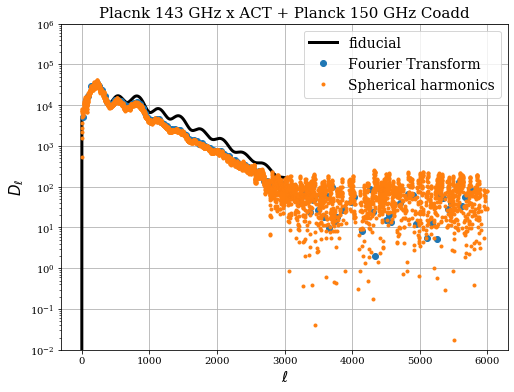

In [32]:
 # Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)
plt.plot(ls,cltt*ls**2.,lw=3,color='k', label = "fiducial")
plt.plot(ell_b,ell_b**2*binned_power,marker="o",ls="none", label = "Fourier Transform")
plt.plot(ell, Dl, '.', label = "Spherical harmonics")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.title("Placnk 143 GHz x ACT + Planck 150 GHz Coadd", fontsize = 15)
plt.ylim(.01 ,1e6)
plt.legend(fontsize = 14)
plt.show()

In the plot above we can quite clearly see some of the acoustic oscillations as we would expect. However, there are a few glaring problems with this spectrum.  Firstly we didn't mask point sources which can be done using the correct Planck mask and the source free ACT maps.  The spectrum also hasn't been corrected for beams or other pixel transfer functions both of which would need to be done for a true analysis.  These effects are easily noticeable at high ell where our power spectra underestimates the fiducial spectra.

Further more we account for the window function using a relatively simple approach, however, to truly decouple it one should use a program such as **Namaster**, **pspy** or **pitas** which explicitly decouple the window functions.

Finally it's important to realize that calculating the error for any cross correlations would need to include knowledge of the noise model which is currently not complete.  

Despite the limitations quick power spectra can be made relatively easily using this approach and can be done with galaxy density maps or other CMB maps.